## Breast cancer detection data challenge

### Important questions 

- What features of a cell are the largest drivers of malignancy?

- How would a physician use your product?

- There is a non-zero cost in time and money to collect each feature about a given cell. How would you  go about determining the most cost-effective method of detecting malignancy?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tools as challengetools
%matplotlib inline

In [2]:
cancer_df = pd.read_csv('breast-cancer-wisconsin.txt',index_col=0)

#### Check proportion of nans

In [3]:
100*cancer_df.isna().sum()/len(cancer_df)

ID                             0.0000
Clump Thickness                0.0000
Uniformity of Cell Size        0.1766
Uniformity of Cell Shape       0.1766
Marginal Adhesion              0.1766
Single Epithelial Cell Size    0.1766
Bare Nuclei                    0.1766
Bland Chromatin                0.1766
Normal Nucleoli                0.1766
Mitoses                        0.1766
Class                          0.1766
dtype: float64

Small number of NaNs, so we can safely just drop them

In [4]:
cancer_df.dropna(inplace=True)

In [5]:
cancer_df.dtypes

ID                              int64
Clump Thickness                 int64
Uniformity of Cell Size        object
Uniformity of Cell Shape       object
Marginal Adhesion              object
Single Epithelial Cell Size    object
Bare Nuclei                    object
Bland Chromatin                object
Normal Nucleoli                object
Mitoses                        object
Class                          object
dtype: object

### Lets look at the cancer classification column. There should only by two possible entries here: 4 for malignant and 2 for benign

In [6]:
cancer_df['Class'].unique()

array(['4', '2', 'No idea', '40', '#', '?', '20'], dtype=object)

In [7]:
cancer_df[['Class','ID']].groupby('Class').count()

,ID
Class,
#,11
2,456
20,5
4,15164
40,151
?,23
No idea,17


#### Since we're only interested in whether a cancer is in class 4 or 2, we can remove all instances of the other classes

In [8]:
def fill_class_na(classval):
    
    '''Return nan if the class is not malignant or benign'''
    
    keepclasses = ['2','4']
    
    if classval not in keepclasses:
        return np.nan
    else:
        if classval == '2':
            return 1
        else:
            return 0 
    

In [9]:
%%time
cancer_df['Class'] = cancer_df['Class'].apply(fill_class_na)

CPU times: user 15.2 ms, sys: 1.75 ms, total: 16.9 ms
Wall time: 16.5 ms


#### Lets see how many nans this produced

In [10]:
100*cancer_df.isna().sum()/len(cancer_df)

ID                             0.000000
Clump Thickness                0.000000
Uniformity of Cell Size        0.000000
Uniformity of Cell Shape       0.000000
Marginal Adhesion              0.000000
Single Epithelial Cell Size    0.000000
Bare Nuclei                    0.000000
Bland Chromatin                0.000000
Normal Nucleoli                0.000000
Mitoses                        0.000000
Class                          1.307892
dtype: float64

In [11]:
cancer_df.dropna(inplace=True)

## Visualization and thoughts about modelling approach

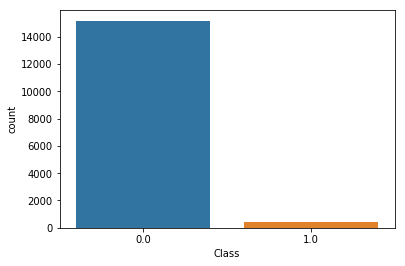

In [12]:
sns.countplot(x='Class',data=cancer_df)
plt.savefig('Breast_cancer_proportions.png',dpi=300)

#### This is a very imbalanced dataset!

In [13]:
cancer_df.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,0.0
1,1107684,6,10,5,5,4,10,6,10,1,0.0
2,691628,8,6,4,10,10,1,3,5,1,0.0
3,1226612,7,5,6,3,3,8,7,4,1,0.0
4,1142706,5,10,10,10,6,10,6,5,2,0.0


#### Convert all the dtypes to numeric

In [14]:
cancer_df = cancer_df.apply(pd.to_numeric,errors='coerce')

In [15]:
len(cancer_df)

15620

#### This may have made some more nans, so lets see how many

In [16]:
100*cancer_df.isna().sum()/len(cancer_df)

ID                             0.000000
Clump Thickness                0.000000
Uniformity of Cell Size        0.000000
Uniformity of Cell Shape       0.000000
Marginal Adhesion              0.000000
Single Epithelial Cell Size    0.000000
Bare Nuclei                    0.102433
Bland Chromatin                0.000000
Normal Nucleoli                0.000000
Mitoses                        0.000000
Class                          0.000000
dtype: float64

In [17]:
cancer_df.dropna(inplace=True)

#### Plot the distorbution of data with hue=Class

In [18]:
#Convert to a format that easy to plot
df_long = pd.melt(cancer_df[list(cancer_df.columns)[1:]], "Class", var_name="Column_name", value_name="Value")

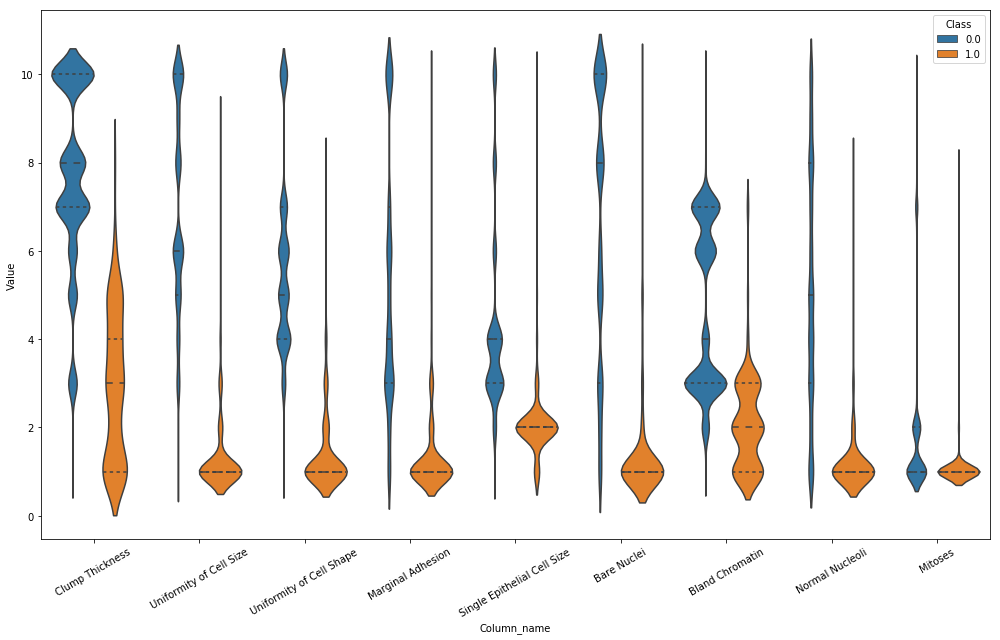

In [19]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)
sns.violinplot(x='Column_name',y='Value',inner='quartile',data=df_long,hue='Class',split=False,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig('Violinplot_cancers.png',dpi=200)
plt.tight_layout()
plt.show()

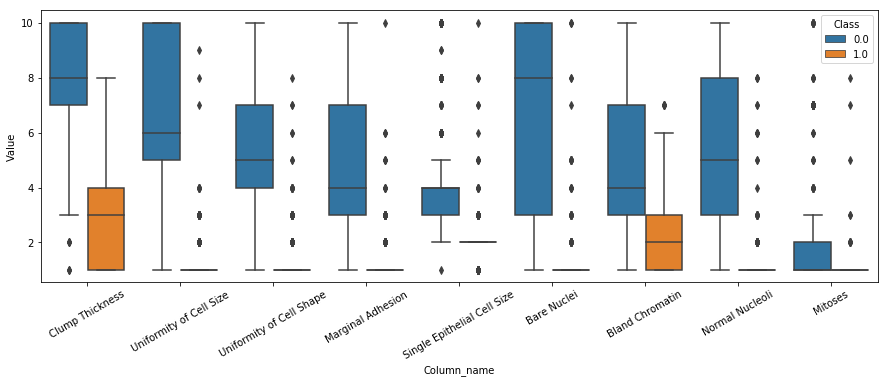

In [20]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.boxplot(x='Column_name',y='Value',data=df_long,hue='Class',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

There is definitely some separation between the features, which gives hope that a model will be able to discriminate between classes 2 and 4

In [21]:
cancer_df[['Class','ID']].groupby('Class').count()

,ID
Class,
0.0,15162
1.0,442


The approach to take here is not obvious: There are many methods of resampling that we could try

#### Lets start by ignoring the class imbalance and using a simple approach to do the classification

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, \
precision_score, roc_auc_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_validate

In [23]:
X = cancer_df[list(cancer_df.columns)[1:-1]]
y = cancer_df['Class']

### How separable are these classes? Apply PCA here to take a look

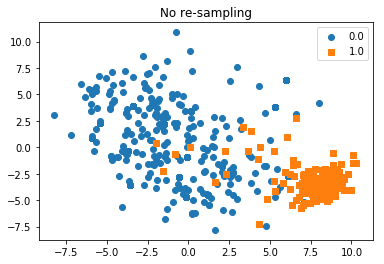

In [24]:
challengetools.plot_2d_space(X, y, 'No re-sampling')

This gives hope that the classes will be linearly separable and that a logistic regression is probably all we need

### Split so that we obtain a holdout set

In [25]:
X_tt, X_holdout, y_tt, y_holdout = train_test_split(X, y, test_size=0.33)

In [26]:
LR = LogisticRegression(penalty='l1',solver='liblinear')

In [27]:
scores = cross_validate(LR,X_tt,y_tt,cv=5,scoring='recall')

In [28]:
scores

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.10580707, 0.04424596, 0.05604315, 0.03739285, 0.03708911]),
 'score_time': array([0.00404787, 0.00212622, 0.00394011, 0.00187993, 0.00212979]),
 'test_score': array([0.98387097, 0.96774194, 0.9516129 , 0.96774194, 1.        ]),
 'train_score': array([0.97165992, 0.97165992, 0.9757085 , 0.97165992, 0.96774194])}

In [29]:
LR.fit(X_tt,y_tt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
y_class = LR.predict(X_holdout)

In [31]:
#As espected, this is very high
accuracy_score(y_holdout,y_class)

0.9988349514563106

In [32]:
#recall score is also good
recall_score(y_holdout,y_class)

0.9699248120300752

In [33]:
#precision score is also good
precision_score(y_holdout,y_class)

0.9847328244274809

In [34]:
#This is a surprisingly good result
print(classification_report(y_holdout,y_class))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5017
         1.0       0.98      0.97      0.98       133

   micro avg       1.00      1.00      1.00      5150
   macro avg       0.99      0.98      0.99      5150
weighted avg       1.00      1.00      1.00      5150



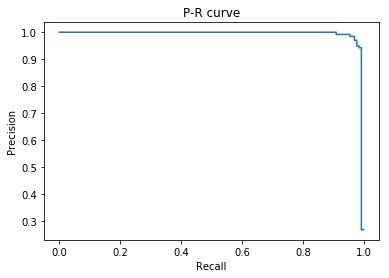

In [35]:
challengetools.precision_recall(y_holdout,LR.predict_proba(X_holdout)[:,1])

#### Lets try undersampling as one method of addressing the class imbalance to see if the results change

In [36]:
from imblearn.under_sampling import RandomUnderSampler

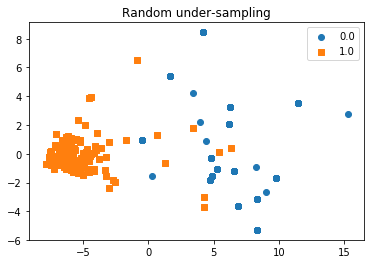

In [37]:
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_tt, y_tt)

challengetools.plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [38]:
print('Number of negative examples: %i' %len(y_rus[y_rus==0]))
print('Number of positive examples: %i' %len(y_rus[y_rus==1]))

Number of negative examples: 309
Number of positive examples: 309


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.33)

In [40]:
LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
y_class = LR.predict(X_holdout)

In [42]:
print(accuracy_score(y_holdout,y_class))
print(recall_score(y_holdout,y_class))
print(precision_score(y_holdout,y_class))

0.998252427184466
0.9774436090225563
0.9558823529411765


The recall score is higher on the undersampled test. Since we probably care most about that, lets o ahead and say that we want to use undersampling in future

In [43]:
#This is a surprisingly good result - the model is basically able to pefectly predict cancer given
#all the features we have here
print(classification_report(y_holdout,y_class))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5017
         1.0       0.96      0.98      0.97       133

   micro avg       1.00      1.00      1.00      5150
   macro avg       0.98      0.99      0.98      5150
weighted avg       1.00      1.00      1.00      5150



### What about feature importances? Since we're using an l1 penalty, we can compute feature importances from the logistic regression

In [44]:
fimportances = LR.coef_[0]

In [45]:
feature_order = np.argsort(abs(fimportances))[::-1]
feature_cols = list(cancer_df.columns)[1:-1]

In [46]:
feature_cols

['Clump Thickness',
 'Uniformity of Cell Size',
 'Uniformity of Cell Shape',
 'Marginal Adhesion',
 'Single Epithelial Cell Size',
 'Bare Nuclei',
 'Bland Chromatin',
 'Normal Nucleoli',
 'Mitoses']

In [47]:
feature_order

array([0, 7, 3, 6, 8, 4, 1, 5, 2])

In [48]:
for i in range(len(feature_cols)):
    ind = feature_order[i]
    print('Feature: %s, importance: %s' %(feature_cols[ind],abs(fimportances[ind])))

Feature: Clump Thickness, importance: 0.7948169478225335
Feature: Normal Nucleoli, importance: 0.7141137195199726
Feature: Marginal Adhesion, importance: 0.5693774339843357
Feature: Bland Chromatin, importance: 0.5445630538367475
Feature: Mitoses, importance: 0.520508532060747
Feature: Single Epithelial Cell Size, importance: 0.4847008547052842
Feature: Uniformity of Cell Size, importance: 0.30887430270087257
Feature: Bare Nuclei, importance: 0.0512898081709674
Feature: Uniformity of Cell Shape, importance: 0.0


We need to write code that will remove one feature at a time, retrain the model and report a score

In [49]:
holdout_recall_scores, holdout_precision_scores, holdout_f1_scores, \
used_columns = challengetools.remove_features_one_by_one(X,y)


-----------------------------------
Number of features: 9
Testing scores from cross validation
[1.         0.97520661 0.99173554 0.98305085 0.97435897]
-----------------------------------
F1 holdout score 0.965278 on 9 features
-----------------------------------
Feature: Clump Thickness, importance: 0.626
Feature: Uniformity of Cell Size, importance: 0.623
Feature: Mitoses, importance: 0.617
Feature: Marginal Adhesion, importance: 0.506
Feature: Bland Chromatin, importance: 0.364
Feature: Bare Nuclei, importance: 0.161
Feature: Single Epithelial Cell Size, importance: 0.110
Feature: Uniformity of Cell Shape, importance: 0.070
Feature: Normal Nucleoli, importance: 0.017
-----------------------------------

-----------------------------------
Number of features: 8
Testing scores from cross validation
[1.         0.99173554 0.99173554 0.98305085 0.98305085]
-----------------------------------
F1 holdout score 0.952055 on 8 features
-----------------------------------
Feature: Uniformity

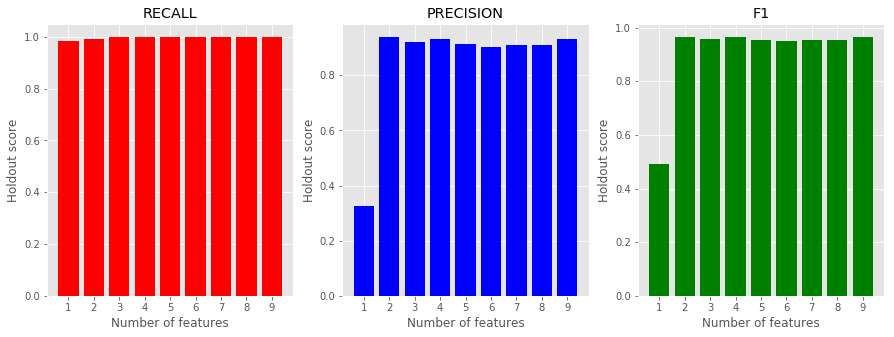

In [54]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.bar(x=np.arange(9,0,-1),height=holdout_recall_scores,color='red')
ax1.set_xticks(np.arange(9,0,-1))
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Holdout score')
ax1.set_title('RECALL')

ax2.bar(x=np.arange(9,0,-1),height=holdout_precision_scores,color='blue')
ax2.set_xticks(np.arange(9,0,-1))
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Holdout score')
ax2.set_title('PRECISION')

ax3.bar(x=np.arange(9,0,-1),height=holdout_f1_scores,color='green')
ax3.set_xticks(np.arange(9,0,-1))
ax3.set_xlabel('Number of features')
ax3.set_ylabel('Holdout score')
ax3.set_title('F1')

plt.savefig('Dropfig_score.png',dpi=200)

In [51]:
print(used_columns)

{9: ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses'], 8: ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Mitoses'], 7: ['Clump Thickness', 'Uniformity of Cell Size', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Mitoses'], 6: ['Clump Thickness', 'Uniformity of Cell Size', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bland Chromatin', 'Mitoses'], 5: ['Clump Thickness', 'Uniformity of Cell Size', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Mitoses'], 4: ['Clump Thickness', 'Uniformity of Cell Size', 'Marginal Adhesion', 'Mitoses'], 3: ['Clump Thickness', 'Uniformity of Cell Size', 'Mitoses'], 2: ['Clump Thickness', 'Uniformity of Cell Size'], 1: ['Uniformity of Cell Size']}
